In [233]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tabulate import tabulate

In [234]:
working_dir = os.getcwd()
windowsize = 1
epochs = 10

In [235]:
def create_timeseries(powers, windowsize):
    rows = len(powers) - windowsize
    x = np.zeros((rows, windowsize))
    y = np.zeros(rows)

    for i in range(rows):
        for j in range(windowsize):
            x[i][j] = powers[i + j]

        y[i] = powers[i + windowsize]

    return x, y

In [236]:
# Read Training Data
df = pd.read_csv(f"{working_dir}/../data/TrainData.csv", sep=',')
power_training = df["POWER"].to_numpy()

# Read Solution
df = pd.read_csv(f"{working_dir}/../data/Solution.csv", sep=',')
actual_power = df["POWER"].to_numpy()
timestamp = df["TIMESTAMP"].to_numpy()

In [237]:
x, y = create_timeseries(power_training, windowsize)
forecast_input = create_timeseries(actual_power, windowsize)[0]

In [238]:
def regression(x, y, model, forecast_input, actual_power, windowsize):
    # Train model
    model.fit(x, y)
    # Predict using trained model
    y_pred = model.predict(forecast_input)

    # Calculate RMSE
    power_comparison = actual_power[windowsize:]
    rmse = np.sqrt(mean_squared_error(power_comparison, y_pred))

    # Return the results of RMSE and the predicted power
    return y_pred, rmse

In [239]:
def ann_model(x, y, forecast_input, actual_power, windowsize, epochs):
    # Process Variables
    scaler = MinMaxScaler()
    X = scaler.fit_transform(x)

    input_data = scaler.transform(forecast_input)
    input_data = input_data.reshape(-1, 1, windowsize)
    
    # Create Model
    model = Sequential()
    model.add(Dense(32, activation='relu', input_dim=1))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='linear'))

    model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

    # Train model
    model.fit(X, y, epochs=epochs, batch_size=32)

    # Predict using trained model
    y_pred_scaled = model.predict(input_data)

    y_pred_ann = scaler.inverse_transform(y_pred_scaled)

    # Calculate RMSE
    power_comparison = actual_power[windowsize:]
    rmse = np.sqrt(mean_squared_error(power_comparison, y_pred_ann))

    return y_pred_ann, rmse

In [240]:
def rnn_model(x, y, forecast_input, actual_power, windowsize, epochs):
    # Process Variables
    scaler = MinMaxScaler()
    X = scaler.fit_transform(x)

    input_data = scaler.transform(forecast_input)

    # Create Model
    model = Sequential()
    model.add(SimpleRNN(units=32, input_shape=(1, windowsize), activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

     # Train model
    model.fit(X, y, epochs=epochs, batch_size=32)

    # Predict using trained model
    y_pred_scaled = model.predict(input_data)

    y_pred_rnn = scaler.inverse_transform(y_pred_scaled)

    # Calculate RMSE
    power_comparison = actual_power[windowsize:]
    rmse = np.sqrt(mean_squared_error(power_comparison, y_pred_rnn))

    return y_pred_rnn, rmse

In [241]:
# Regressions
lr = regression(x, y, LinearRegression(), forecast_input, actual_power, windowsize)
svr = regression(x, y, SVR(), forecast_input, actual_power, windowsize)

# Neural Networks
ann = ann_model(x, y, forecast_input, actual_power, windowsize, epochs)
rnn = rnn_model(x, y, forecast_input, actual_power, windowsize, epochs)

# Print results
print(f"{'RMSE for LR model:':<20}{lr[1]}")
print(f"{'RMSE for SVR model:':<20}{svr[1]}")
print(f"{'RMSE for ANN model:':<20}{ann[1]}")
print(f"{'RMSE for RNN model:':<20}{rnn[1]}")

Epoch 1/10
503/503 [==============================] - 1s 1ms/step - loss: 0.0242 - root_mean_squared_error: 0.1556
Epoch 2/10
503/503 [==============================] - 1s 2ms/step - loss: 0.0115 - root_mean_squared_error: 0.1070
Epoch 3/10
503/503 [==============================] - 1s 1ms/step - loss: 0.0115 - root_mean_squared_error: 0.1070
Epoch 4/10
503/503 [==============================] - 1s 1ms/step - loss: 0.0115 - root_mean_squared_error: 0.1071
Epoch 5/10
503/503 [==============================] - 1s 1ms/step - loss: 0.0115 - root_mean_squared_error: 0.1071
Epoch 6/10
503/503 [==============================] - 1s 1ms/step - loss: 0.0115 - root_mean_squared_error: 0.1072
Epoch 7/10
503/503 [==============================] - 1s 2ms/step - loss: 0.0114 - root_mean_squared_error: 0.1070
Epoch 8/10
503/503 [==============================] - 1s 2ms/step - loss: 0.0115 - root_mean_squared_error: 0.1071
Epoch 9/10
503/503 [==============================] - 1s 1ms/step - loss: 0.0115

In [242]:
# Save Results to Files
forecast_template = pd.read_csv(f'{working_dir}/../data/ForecastTemplate.csv')

# LR forecast template output
def print_format(data):
    a = np.zeros((720, 1), dtype=float)
    for i in range(len(data)):
        if (i == 0):
            a[i] = data[i]
        a[i + 1] = data[i]
        
    return a

forecast_template['FORECAST'] = print_format(lr[0])
forecast_template.to_csv(f'{working_dir}/results/ForecastTemplate3-LR.csv', index=False)

# SVR forecast template
forecast_template['FORECAST'] = print_format(svr[0])
forecast_template.to_csv(f'{working_dir}/results/ForecastTemplate3-SVR.csv', index=False)

# ANN forecast template
forecast_template['FORECAST'] = print_format(ann[0])
forecast_template.to_csv(f'{working_dir}/results/ForecastTemplate3-ANN.csv', index=False)

# RNN forecast template
forecast_template['FORECAST'] = print_format(rnn[0])
forecast_template.to_csv(f'{working_dir}/results/ForecastTemplate3-RNN.csv', index=False)

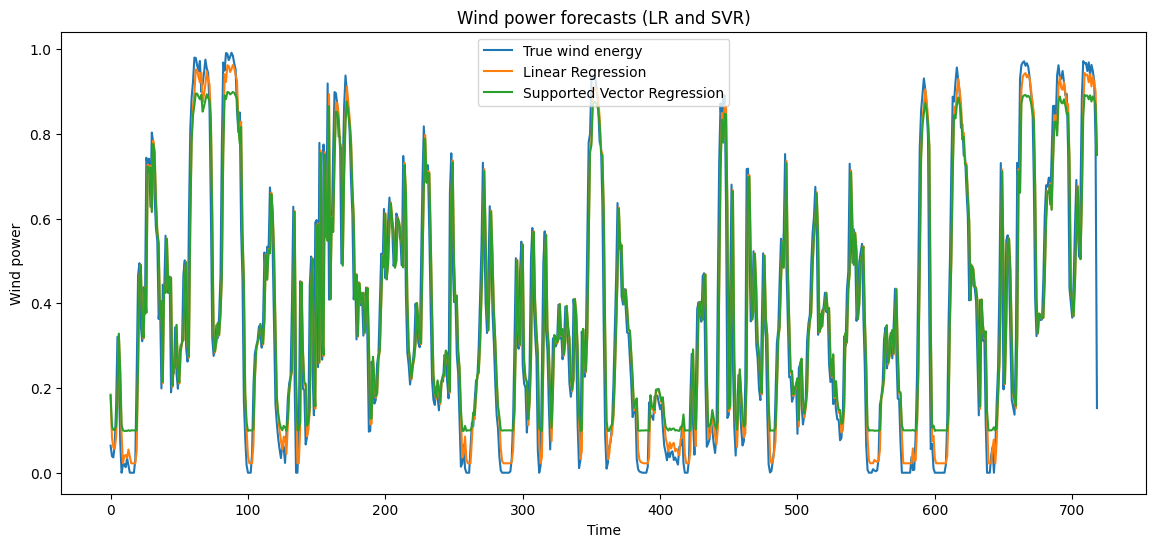

In [243]:
# Plot the time-series figure for LR and SVR
plt.figure(figsize=(14, 6))
plt.plot(actual_power[windowsize:], label="True wind energy")
plt.plot(lr[0], label="Linear Regression")
plt.plot(svr[0], label="Supported Vector Regression")
plt.xlabel("Time")
plt.ylabel("Wind power")
plt.title("Wind power forecasts (LR and SVR)")
plt.legend()
plt.show()

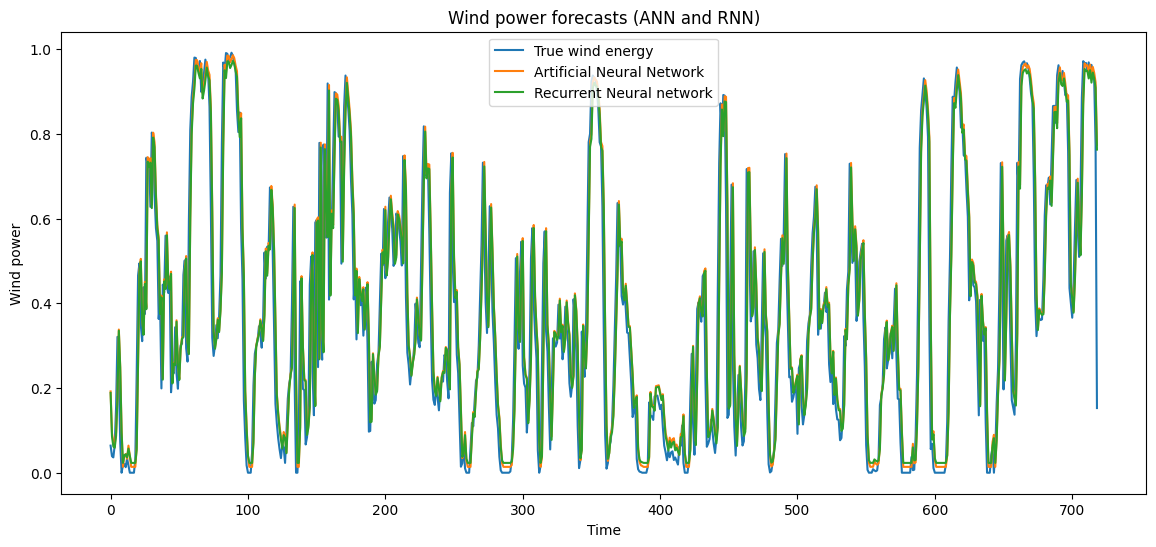

In [244]:
# Plot the time-series figure for ANN and RNN
plt.figure(figsize=(14, 6))
plt.plot(actual_power[windowsize:], label="True wind energy")
plt.plot(ann[0], label="Artificial Neural Network")
plt.plot(rnn[0], label="Recurrent Neural network")
plt.xlabel("Time")
plt.ylabel("Wind power")
plt.title("Wind power forecasts (ANN and RNN)")
plt.legend()
plt.show()

In [245]:
# Table for presenting and comparing forecasting accuracy
table = [["LR", lr[1]], ["SVR", svr[1]], ["ANN", ann[1]], ["RNN", rnn[1]]]
table = tabulate(table, headers=["Model", "RMSE"], tablefmt="pretty")
print(table)

+-------+---------------------+
| Model |        RMSE         |
+-------+---------------------+
|  LR   | 0.12599235274603401 |
|  SVR  | 0.12928081531313518 |
|  ANN  | 0.12723749555232589 |
|  RNN  | 0.12633455964574572 |
+-------+---------------------+
